In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score
from tune_sklearn import TuneSearchCV
from ray import tune
from catboost import CatBoostClassifier
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# в качестве данных был взят датасет с kaggle
# https://www.kaggle.com/prakharrathi25/banking-dataset-marketing-targets
train = pd.read_csv('/content/drive/MyDrive/портфолио/Project "Marketing Targets"/train.csv', delimiter=";")
test = pd.read_csv('/content/drive/MyDrive/портфолио/Project "Marketing Targets"/test.csv', delimiter=";")

bank client data:

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

# related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)
# other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [ ]:
# посмотрим на данные
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [ ]:
# проверим, сбалансированность классов
train['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

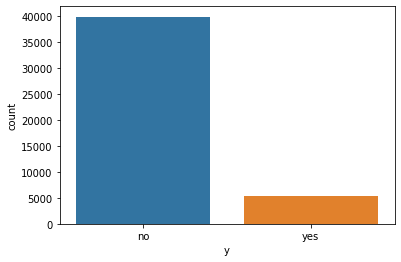

In [ ]:
# выборка несбалансированная
sns.countplot(x='y', data=train)

In [ ]:
#проверим, нет ли NaN в столбцах
for i in train.columns:
  print('{} {}'.format(i, train[i].notnull().unique()))

age [ True]
job [ True]
marital [ True]
education [ True]
default [ True]
balance [ True]
housing [ True]
loan [ True]
contact [ True]
day [ True]
month [ True]
duration [ True]
campaign [ True]
pdays [ True]
previous [ True]
poutcome [ True]
y [ True]


In [ ]:
# посмотрим, на типы признаков в датасете (категориальные необходимо будет преобразовать в числовые)
train.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

# визуализация данных

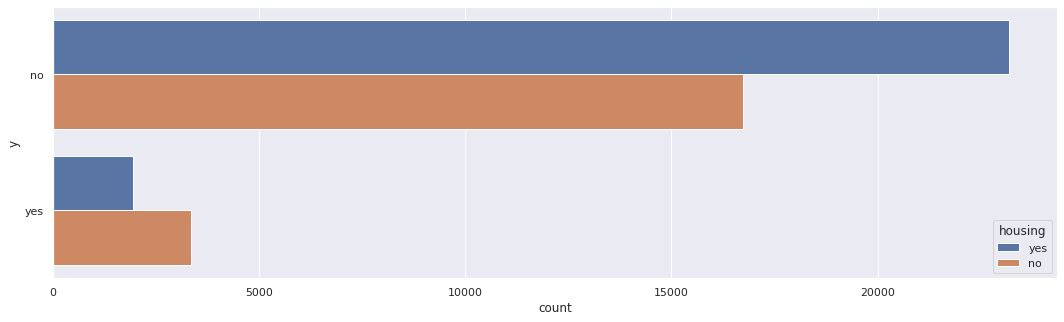

In [ ]:
# количество людей с оформлением срочного вклада в зависимости от наличия кредита на недвижимость
plt.figure(figsize=(18, 5)) 
sns.set_theme(style="darkgrid")
sns.countplot(y="y", hue="housing", data=train)

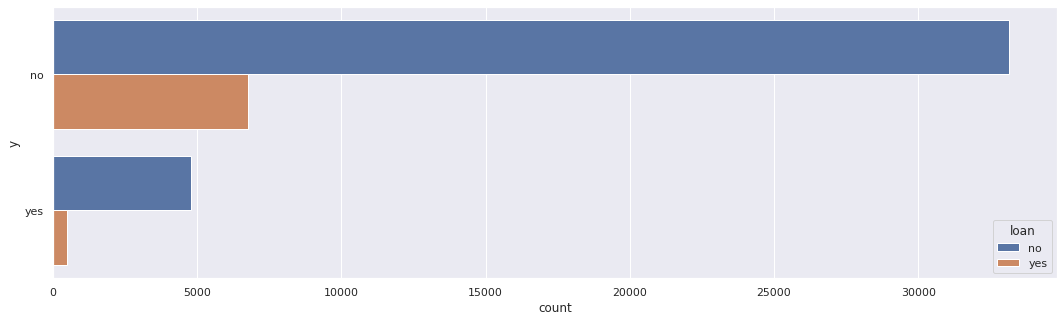

In [ ]:
# количество людей с оформлением срочного вклада в зависимости от наличия персонального кредита
plt.figure(figsize=(18, 5)) 
sns.set_theme(style="darkgrid")
sns.countplot(y="y", hue="loan", data=train)

Наличие кредита на недвижимость сильнее влияет на отказ от оформления вклада в отличие от персонального кредита

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-3000.0, 6000.0)

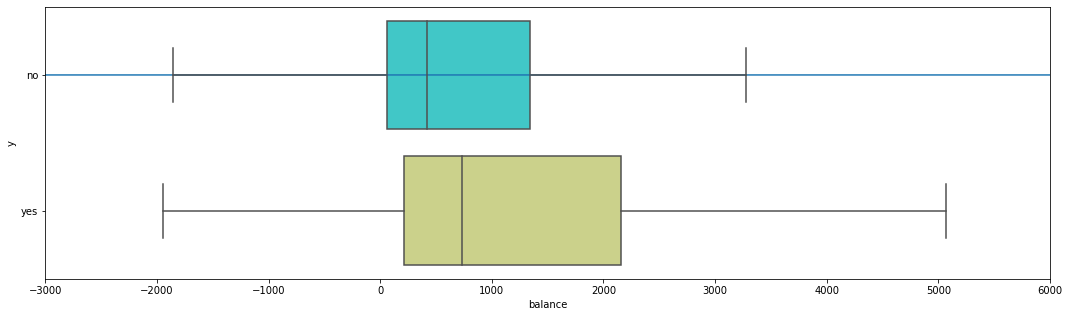

In [ ]:
# распределение среднего годового остатка у тех, кто оформил и нет срочный вклад
plt.figure(figsize=(18, 5)) 
sns.distplot(train['balance'])
sns.boxplot(x="balance", y="y", data=train, showfliers=False, palette='rainbow', orient='h')
plt.xlim(-3000, 6000)

медианный средний годовой остаток у людей с оформлением менее чем на 500 € больше, чем у людей без оформления

# предобработка данных

In [ ]:
# преобразуем все категориальные (бинарные и строковые) признаки в числовые
def data_preprocessing(df):
  num_cols = df.select_dtypes(include=int).columns.to_list()

  binary_cols = []
  for i in df.columns:
    if sorted(list(df[i].unique()))==['no', 'yes']:
      binary_cols.append(i)
      df.loc[(df[i] == 'no'), i] = 0
      df.loc[(df[i] != 0), i] = 1
      df[i] = df[i].astype(int)

  str_cols = df.columns.difference(binary_cols+num_cols)
  str_dict = dict(enumerate(str_cols))
  le = LabelEncoder()
  df[str_cols] = df[str_cols].apply(le.fit_transform)
  return df

In [ ]:
train = data_preprocessing(train)
test = data_preprocessing(test)

In [ ]:
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9,1,2,0,825,0,0,0,17,9,977,3,-1,0,3,1
45207,71,5,0,0,0,1729,0,0,0,17,9,456,2,-1,0,3,1
45208,72,5,1,1,0,5715,0,0,0,17,9,1127,5,184,3,2,1
45209,57,1,1,1,0,668,0,0,1,17,9,508,4,-1,0,3,0


In [ ]:
train.dtypes

age          int64
job          int64
marital      int64
education    int64
default      int64
balance      int64
housing      int64
loan         int64
contact      int64
day          int64
month        int64
duration     int64
campaign     int64
pdays        int64
previous     int64
poutcome     int64
y            int64
dtype: object

Text(0.5, 1.0, 'Тепловая карта корреляции')

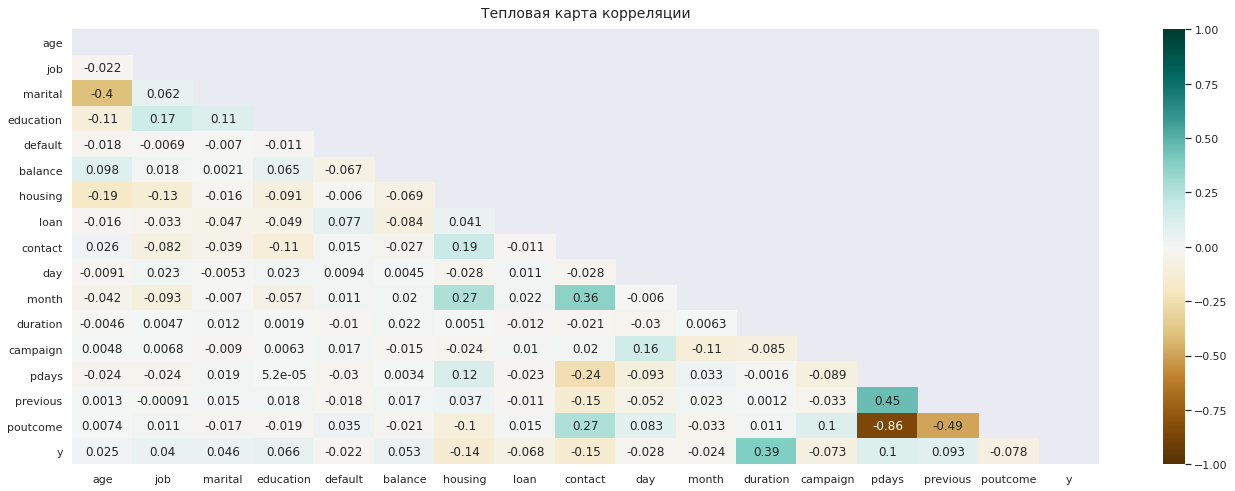

In [ ]:
plt.figure(figsize=(23, 8)) 
mask = np.triu(np.ones_like(train.corr(), dtype=np.bool))
heatmap = sns.heatmap(train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Тепловая карта корреляции', fontdict={'fontsize':14}, pad=12)

Заметна наиболее выраженная положительная корреляция между previous (количество контактов, выполненных до этой кампании для этого клиента) и pdays (количество дней, прошедших с момента последнего обращения к клиенту в рамках предыдущей кампании), а отрицательная - poutcome (результат предыдущей маркетинговой кампании) и pdays

C y (таргетом) наиболее связан duration (время общения с клиентом во время рекламы вклада)

# обучение модели

In [ ]:
# отношение количества строк с 0 к 1 в y
rat = int(round(len(train.loc[train['y']==0])/len(train.loc[train['y']==1]), 0))
rat

8

In [ ]:
# извлекаем признаки и таргет
X_train =  train[train.columns.difference(['y'])]
y_train = train['y']
X_test = test[test.columns.difference(['y'])]
y_test = test['y']

In [ ]:
# воспользуемся автоматическим подбором гиперпараметров модели ray-tune
# https://github.com/ray-project/tune-sklearn
# задаём параметры, из диапазона значений которых надо выбрать лучшее
param_dists = {
    'iterations': tune.choice([i*1000 for i in range(1, 6)]),
    'learning_rate': tune.choice([i*0.001 for i in range(1, 21)]),
    'bootstrap_type': tune.choice(['Bayesian', 'Bernoulli', 'MVS', 'No']), 
    'depth': tune.choice([i for i in range(2, 17)]),
    'class_weights': tune.choice([{0:1, 1:i} for i in range(1, rat+5)]),
    'random_seed': tune.choice([23])
}

hyperopt_tune_search = TuneSearchCV(CatBoostClassifier(),
    param_distributions=param_dists,
    n_trials=2,
    early_stopping=True,
    max_iters=10,
    search_optimization="hyperopt"
)

hts = hyperopt_tune_search.fit(X_train, y_train)


In [ ]:
# значения метрик получились достаточно высокие (90%+), что может говорить качественности модели классификации
y_pred = hts.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))
print(roc_auc_score(y_test, y_pred))

[[3995    5]
 [  50  471]]
(0.9894957983193278, 0.9040307101727447, 0.9448345035105317, None)
0.9513903550863724
